In [1]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import xgboost
import shap
import numpy as np
import pandas as pd
import matplotlib.pylab as pl
import pickle

# print the JS visualization code to the notebook
shap.initjs()

In [2]:
# Load dataset

# with open('../data/price_data.pickle', 'wb') as f:
#     pickle.dump(price_data, f)

with open('../data/final_dataset.pickle', 'rb') as f:
    final_dataset = pickle.load(f)

In [3]:
def encode_cats(categoricals, numericals, df):
    """
    Takes in a list of categorical columns and a list of numerical columns and returns the dataframe with encoded variables
    """
    ohe = OneHotEncoder(sparse=False, drop='first')
    cat_matrix = ohe.fit_transform(df.loc[:, categoricals])
    X_ohe = pd.DataFrame(cat_matrix,
                         columns=ohe.get_feature_names(categoricals), #create meaningful column names
                         index=df.index) #keep the same index values
    
    return pd.concat([df.loc[:, numericals], X_ohe], axis=1)

In [4]:
# Encode categorical variables
categoricals = list(final_dataset.select_dtypes('object').columns)
numericals = list(final_dataset.select_dtypes(['int64', 'float64', 'int32', 'float32']).columns)
final_dataset = encode_cats(categoricals, numericals, final_dataset)

for i in range(len(final_dataset['direction'])):
    if final_dataset['direction'][i] == -1:
        final_dataset['direction'][i] = 2

In [5]:
X = final_dataset.loc[:, "bearish":]
y = final_dataset['direction'].values

In [6]:
# Create train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)
d_train = xgboost.DMatrix(X_train, label=y_train)
d_test = xgboost.DMatrix(X_test, label=y_test)

In [7]:
# Train the model
params = {
    "eta": 0.01,
    "objective": "multi:softprob",
    "subsample": 0.5,
    "base_score": np.mean(y_train),
    "eval_metric": ["merror", "mlogloss"],
    "num_class": 3,
    "seed": 42
}
model = xgboost.train(params, dtrain = d_train, num_boost_round = 5000, evals = [(d_test, "test")], verbose_eval=100, early_stopping_rounds=20)

[0]	test-merror:0.37433	test-mlogloss:1.09328
Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 20 rounds.
[100]	test-merror:0.29946	test-mlogloss:0.77778
[200]	test-merror:0.28342	test-mlogloss:0.66611
[300]	test-merror:0.27273	test-mlogloss:0.61793
[400]	test-merror:0.26738	test-mlogloss:0.59136
[500]	test-merror:0.27273	test-mlogloss:0.58025
Stopping. Best iteration:
[510]	test-merror:0.26203	test-mlogloss:0.57954



In [9]:
# Classic feature distributions
# Sometimes feature importance calculations can calculate eachother
# Re-iterates the importance of using SHAP for model interpretation

In [ ]:
xgboost.plot_importance(model)
pl.title("xgboost.plot_importance(model)")
pl.show()

In [ ]:
xgboost.plot_importance(model, importance_type="cover")
pl.title('xgboost.plot_importance(model, importance_type="cover")')
pl.show()

In [8]:
# Explain Predictions

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

In [ ]:
# Visualize a single prediction
shap.force_plot(explainer.expected_value[1], shap_values[0])

In [ ]:
# Visualize many predictions
shap.force_plot(explainer.expected_value[1], shap_values[1])

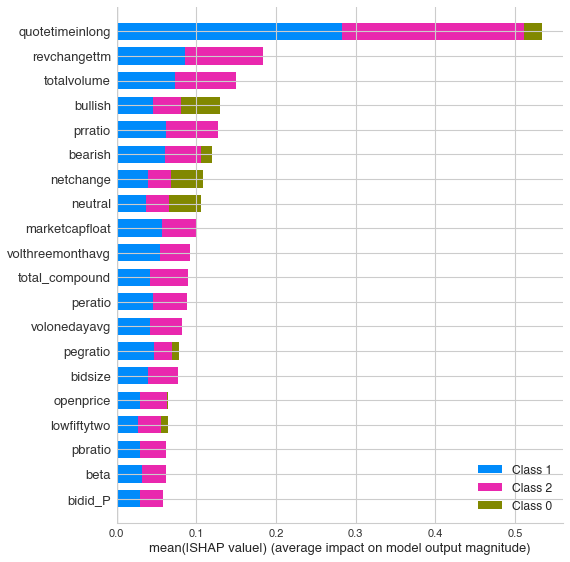

In [9]:
# Bar chart of mean importance
# This takes the average of the SHAP value magnitudes across the dataset and plots it as a simple bar chart.
shap.summary_plot(shap_values, X, plot_type="bar")

In [ ]:
# SHAP Summary Plot

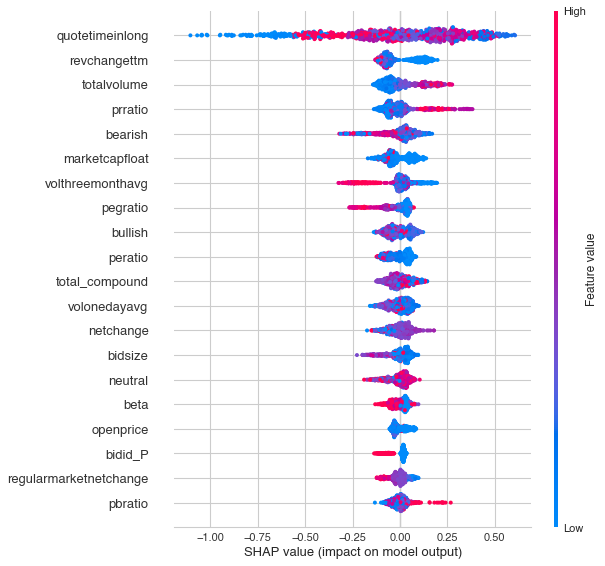

In [13]:
shap.summary_plot(shap_values[1], X)